### Abstract
This Jupyter notebook demonstrates the use of Microsoft CNTK to perform a classification task using CIFAR-10 images.

Here, a convolution neural network with maxpooling and dropout is used.

##### Tested on Microsoft CNTK V2.0 Beta 15 (https://github.com/Microsoft/CNTK/)

##### Overview:
1. Import Libraries 
2. Configure Parameters
    1. Dataset Specifications
    2. Modify Destination Folders
    3. Modify Training and Evaluation Parameters
3. Visualize Sample from Dataset
4. Configure Reader
5. Configure Neural Network Model
6. Configure Trainer
7. Configure Evaluation
8. Train and Evaluate Convolution Network Model

### Step 1: Import Libraries

Use <i>conda install</i> to install additional libraries that are not in the CNTK package:
- scikit-learn


In [12]:
# Required libraries
from PIL import Image
import numpy as np
import pickle as cp
import os
import sys
import tarfile
import xml.etree.cElementTree as et
import xml.dom.minidom
import matplotlib.pyplot as plt
import re
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools

try: 
    from urllib.request import urlretrieve 
except ImportError: 
    from urllib import urlretrieve

# Required CNTK libraries
import cntk as C
from cntk.layers import default_options, Convolution, MaxPooling, AveragePooling, Dropout, BatchNormalization, Dense, Sequential, For
from cntk.io import MinibatchSource, ImageDeserializer, StreamDef, StreamDefs
import cntk.io.transforms as xforms 
from cntk.initializer import glorot_uniform, he_normal
from cntk import Trainer, combine, load_model
from cntk.learners import momentum_sgd, learning_rate_schedule, UnitType, momentum_as_time_constant_schedule
from cntk import cross_entropy_with_softmax, classification_error, relu, sequence, softmax, element_times
from cntk.logging import *

# Config matplotlib for inline plotting
%matplotlib inline

### Step 2: Configure Parameters

#### 2.A. Dataset Specifications  </span>

##### <span style="color:red">*</span> CIFAR-10
Taken from 

https://www.cs.toronto.edu/~kriz/cifar.html

Specifications:
- 50000 training images and 10000 test images
- all images are 32x32x3
- Each image is classified as one of 10 classes as shown below:
    - airplane
    - automobile
    - bird
    - cat
    - deer
    - dog
    - frog
    - horse
    - ship
    - truck

In [2]:
evalOnly        = False

dataSet         = 'CIFAR-10'

imgSize_y       = 32
imgSize_x       = 32
num_channels    = 3
num_labels      = 10
numFeature      = imgSize_y * imgSize_x * num_channels
label_names     = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

#### 2.B. Modify Data and Model Folders

In [3]:
# where the dataset for CIFAR-10 is stored
data_dir        = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))) + '/data/cifar-10/'
# where the trained model will be saved into
model_directory = './model/'
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
# mapping file for train images
train_file      = data_dir + 'train_map.txt'
# mapping file for test images
test_file       = data_dir + 'test_map.txt'
# mean file
mean_file       = data_dir + 'CIFAR-10_mean.xml'

#### 2.C. Modify Training and Evaluation Parameters (Optional)

In [4]:
# Training configuration
train_max_epochs       = 10
train_epoch_size       = 50000 # corresponds to training sample size
train_minibatch_size   = 64

# Evaluation configuration
eval_epoch_size        = 10000 # corresponds to evaluation sample size
eval_minibatch_size    = 16        

### Step 3: Visualize Sample from Dataset

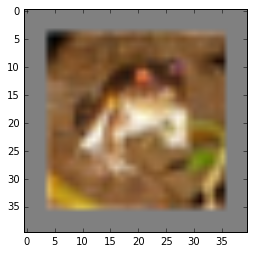

In [5]:
with open(train_file, 'r') as input_file:
    line = input_file.readline()
    train_data = re.split(r'\t|\n', line)
    # Load test image
    im = Image.open(train_data[0])
    plt.imshow(im)
    plt.show()
    plt.close()

### Step 4: Configure Reader

##### Possible optimizations
- Adding noise to the data can often improves generalization error. You can augment the training set by adding noise (generated with numpy, hint: use numpy.random) to the training images.
- Distort the images with affine transformation (translations or rotations)

In [6]:
# Define reader to feed data into network
def create_reader(map_file, mean_file, train):
    transforms = []
    if train:
            transforms += [
            xforms.crop(crop_type='randomside', side_ratio=0.8)
        ]
    transforms += [
            xforms.scale(width=imgSize_x, height=imgSize_y, channels=num_channels, interpolations='linear'),
            xforms.mean(mean_file)
        ]

    # deserializer
    deserializer = ImageDeserializer(map_file, StreamDefs(
        features = StreamDef(field='image', transforms=transforms), # first column in map file is referred to as 'image'
        labels   = StreamDef(field='label', shape=num_labels)      # and second as 'label'
    ))
    
    if num_channels == 1: # modify deserializer to support gray scale images
        deserializer['grayscale'] = True 
    
    return MinibatchSource(deserializer)

### Step 5: Configure Neural Network Models

In [7]:
# Define network

def create_model_MLP(input, out_dims):
    with default_options(activation=relu):
            model = Sequential([
                Dense(10, init=glorot_uniform()),
                #Dense(200, init=glorot_uniform()),
                #Dense(150, init=glorot_uniform()),
                Dense(out_dims, init=glorot_uniform(), activation=None)
            ])

    return model(input)


def create_model_CONV(input, out_dims):
    with default_options(activation=relu):
        model = Sequential([            
            Convolution((5,5), 50, init=glorot_uniform()),
            MaxPooling((3,3), strides=(2,2)),
            Convolution((5,5), 50, init=glorot_uniform()),
            MaxPooling((3,3), strides=(2,2)),
            Convolution((5,5), 50, init=glorot_uniform()),
            MaxPooling((3,3), strides=(2,2)),
            Dense(out_dims, init=glorot_uniform(), activation=None)
        ])
    return model(input)

def create_basic_model(input, out_dims):
    
    net = Convolution((5,5), 32, init=glorot_uniform(), activation=relu, pad=True)(input)
    net = MaxPooling((3,3), strides=(2,2))(net)

    net = Convolution((5,5), 32, init=glorot_uniform(), activation=relu, pad=True)(net)
    net = MaxPooling((3,3), strides=(2,2))(net)

    net = Convolution((5,5), 64, init=glorot_uniform(), activation=relu, pad=True)(net)
    net = MaxPooling((3,3), strides=(2,2))(net)
    
    net = Dense(64, init=glorot_uniform())(net)
    net = Dense(out_dims, init=glorot_uniform(), activation=None)(net)
    
    return net

def create_basic_model_terse(input, out_dims):

    with default_options(activation=relu):
        model = Sequential([
            For(range(3), lambda i: [
                Convolution((5,5), [32,32,64][i], init=glorot_uniform(), pad=True),
                MaxPooling((3,3), strides=(2,2))
            ]),
            Dense(64, init=glorot_uniform()),
            Dense(out_dims, init=glorot_uniform(), activation=None)
        ])

    return model(input)


def create_basic_model_with_batch_normalization(input, out_dims):

    with default_options(activation=relu):
        model = Sequential([
            For(range(3), lambda i: [
                Convolution((5,5), [32,32,64][i], init=glorot_uniform(), pad=True),
                BatchNormalization(map_rank=1),
                MaxPooling((3,3), strides=(2,2))
            ]),
            Dense(64, init=glorot_uniform()),
            BatchNormalization(map_rank=1),
            Dense(out_dims, init=glorot_uniform(), activation=None)
        ])

    return model(input)

### Step 6: Configure Trainer

In [8]:
# Helper function to allow reuse of cross_entropy and classification_error functions
def create_criterion_function(model):
    labels = C.Placeholder(name='labels')
    ce     = cross_entropy_with_softmax(model, labels)
    errs   = classification_error      (model, labels)
    return combine ([ce, errs])

# Define training
def train(reader_train, model_func):
    # Input variable denoting the features data
    input_var = C.input_variable((num_channels, imgSize_y, imgSize_x), name = 'input_var')
    
    # Normalize the input so that the pixel value will be scaled from 0-255 to 0-1
    feature_scale = 1.0 / 256.0
    input_var_norm = element_times(feature_scale, input_var)
    
    # create new model and apply it to input
    z = model_func(input_var_norm, out_dims=num_labels)

    # Define loss and metric
    criterion = create_criterion_function(z)
    criterion.replace_placeholders({criterion.placeholders[0]: C.input_variable(num_labels)})
    
    # Set training parameters
    lr_per_mb              = [0.05]*10 + [0.025]*10 + [0.01]
    lr_schedule            = learning_rate_schedule(lr_per_mb, epoch_size=train_epoch_size, unit=UnitType.minibatch)#sample)
    mm_time_constant       = -train_minibatch_size/np.log(0.90)
    mm_schedule            = momentum_as_time_constant_schedule(mm_time_constant)
    l2_reg_weight          = 0.001    
    
    # trainer object
    # with momentum
    learner     = momentum_sgd(criterion.parameters, 
                               lr_schedule, mm_schedule, 
                               l2_regularization_weight=l2_reg_weight)
    
    progress_printer = ProgressPrinter(tag='Training', num_epochs=train_max_epochs)
    
    # instantiate trainer: model, cross entropy, classification error, learning params
    trainer     = Trainer(z, criterion, learner, progress_printer)

    # define mapping from reader streams to network inputs
    input_map = {
        criterion.arguments[0]: reader_train.streams.features,
        criterion.arguments[1]: reader_train.streams.labels
    }

    log_number_of_parameters(z);
    print();
    
    # perform model training
    batch_index = 0
    plot_data = {'batchindex':[], 'loss':[], 'error':[]}
    for epoch in range(train_max_epochs):       # loop over epochs
        sample_count = 0
        while sample_count < train_epoch_size:  # loop over minibatches in the epoch
            data = reader_train.next_minibatch(min(train_minibatch_size, train_epoch_size - sample_count), input_map=input_map) # fetch minibatch.
            trainer.train_minibatch(data)                                   # update model with it

            sample_count += data[criterion.arguments[1]].num_samples                     # count samples processed so far
            
            # For visualization...            
            plot_data['batchindex'].append(batch_index)
            plot_data['loss'].append(trainer.previous_minibatch_loss_average)
            plot_data['error'].append(trainer.previous_minibatch_evaluation_average)
            
            batch_index += 1
        trainer.summarize_training_progress()
        
    # save final trained model
    z.save_model(os.path.join(model_directory, dataSet + ".dnn"))
    
    return softmax(z)

### Step 7: Configure Evaluation

In [9]:
# Define evaluation
def evaluate(reader_test):
    model_filename = model_directory + dataSet + '.dnn'
    if not os.path.isfile(model_filename):
        print (model_filename, ' does not exist. Perform training step first.')
    else:       
        # load trained model
        z = load_model(model_filename)
        
        # Define loss and metric
        criterion = create_criterion_function(z)
        criterion.replace_placeholders({criterion.placeholders[0]: C.input_variable(num_labels)})
        
        # currently a dummy_learner is required to instantiate trainer
        # Set training parameters - will not be used 
        lr_per_minibatch       = learning_rate_schedule([0.01]*10 + [0.003]*10 + [0.001], UnitType.minibatch, eval_epoch_size)
        momentum_time_constant = momentum_as_time_constant_schedule(-eval_minibatch_size/np.log(0.9))
        l2_reg_weight          = 0.001

        dummy_learner     = momentum_sgd(criterion.parameters, 
                                   lr = lr_per_minibatch, momentum = momentum_time_constant, 
                                   l2_regularization_weight=l2_reg_weight)
        
        progress_printer = ProgressPrinter(tag='Evaluation', num_epochs=0)
        evaluator = Trainer(z, criterion, dummy_learner, progress_printer)

        
        # process minibatches and evaluate the model
        metric_numer    = 0
        metric_denom    = 0
        sample_count    = 0
        minibatch_index = 0

        while sample_count < eval_epoch_size:
            current_minibatch = min(eval_minibatch_size, eval_epoch_size - sample_count)

            # Fetch next test min batch.
            data = reader_test.next_minibatch(current_minibatch, input_map={  # fetch minibatch
                                                criterion.arguments[0]: reader_test.streams.features,
                                                criterion.arguments[1]: reader_test.streams.labels
            })

            # minibatch data to be trained with
            metric_numer += evaluator.test_minibatch(data) * current_minibatch
            metric_denom += current_minibatch

            # Keep track of the number of samples processed so far.
            sample_count += data[criterion.arguments[1]].num_samples
            minibatch_index += 1
            # log progress
            progress_printer.update(0, 
                                    data[criterion.arguments[1]].num_samples, 
                                    metric_numer/metric_denom)
            

        print("")
        print("Final Results: Minibatch[1-{}]: errs = {:0.1f}% * {}".format(minibatch_index+1, (metric_numer*100.0)/metric_denom, metric_denom))
        print("")
        
        return softmax(z)

### Step 8a: Train Fully Connected Model

In [10]:
if not evalOnly:
    # Read Train Data
    reader_train = create_reader(train_file, mean_file, True)
    # Start Training
    pred_train = train(reader_train, model_func=create_basic_model_with_batch_normalization)

Training 117290 parameters in 18 parameter tensors.

Finished Epoch[1 of 10]: [Training] loss = 1.447996 * 50000, metric = 52.46% * 50000 38.687s (1292.4 samples/s);
Finished Epoch[2 of 10]: [Training] loss = 1.100899 * 50000, metric = 38.89% * 50000 35.484s (1409.1 samples/s);
Finished Epoch[3 of 10]: [Training] loss = 0.968843 * 50000, metric = 34.02% * 50000 37.006s (1351.1 samples/s);
Finished Epoch[4 of 10]: [Training] loss = 0.882383 * 50000, metric = 30.91% * 50000 35.276s (1417.4 samples/s);
Finished Epoch[5 of 10]: [Training] loss = 0.828470 * 50000, metric = 28.93% * 50000 36.732s (1361.2 samples/s);
Finished Epoch[6 of 10]: [Training] loss = 0.791279 * 50000, metric = 27.48% * 50000 34.444s (1451.6 samples/s);
Finished Epoch[7 of 10]: [Training] loss = 0.750380 * 50000, metric = 26.12% * 50000 35.841s (1395.1 samples/s);
Finished Epoch[8 of 10]: [Training] loss = 0.728920 * 50000, metric = 25.25% * 50000 36.177s (1382.1 samples/s);
Finished Epoch[9 of 10]: [Training] loss = 

### Step 8b: Evaluate Fully Connected Model

In [13]:
# Read Test Data
reader_test  = create_reader(test_file, mean_file, False)
    
# Start Evaluation
pred_eval = evaluate(reader_test)


Final Results: Minibatch[1-626]: errs = 25.9% * 10000



### Step 8c: Test Fully Connected Model with Sample Image

In [14]:
def eval(image_num):
    
    image_path = data_dir + 'test/' + image_num + '.png'
    # Prepare image
    im = Image.open(image_path)
    plt.imshow(im)
    plt.show()
    plt.close()
    image_data   = np.array(im, dtype=np.float32)
    im.close()

    image_data = image_data.reshape(imgSize_y, imgSize_x, num_channels)

    image_data   = np.ascontiguousarray(np.transpose(image_data, (2, 0, 1)))

    # Load trained model
    model_filename = model_directory + '/' + dataSet + '.dnn'
    if not os.path.isfile(model_filename):
        print (model_filename, ' does not exist. Perform training step first.')
    else:       
        # load trained model
        z = load_model(model_filename)
        # Apply softmax to calculate regression/probabilities
        pred_op = softmax(z)

    result       = np.squeeze(pred_op.eval({pred_op.arguments[0]:[image_data]}))

    # Return top results:
    top_count = 3
    result_indices = (-np.array(result)).argsort()[:top_count]

    print("Ranked predictions:")
    for j in range(top_count):
        print("\tLabel: {:10s}, confidence: {:.2f}%".format(label_names[result_indices[j]], result[result_indices[j]] * 100))

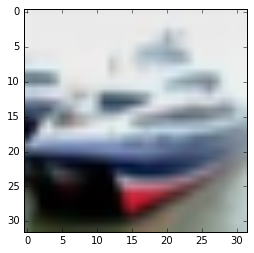

Ranked predictions:
	Label: ship      , confidence: 35.13%
	Label: horse     , confidence: 19.83%
	Label: automobile, confidence: 14.99%


In [15]:
image_num = "00001"

eval(image_num)

### Step 8d: Display Confusion Matrix for Fully Connected Model

In [16]:
def plot_confusion_matrix(cm):
    
    fig = plt.figure(figsize = (15,15))
    fig1 = fig.add_subplot(111)
    confmat = fig1.matshow(cm, cmap=plt.cm.Blues)
    fig1.set_title('Confusion Matrix')
    plt.colorbar(confmat, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(label_names))
    plt.xticks(tick_marks, label_names, rotation=90)
    plt.yticks(tick_marks, label_names)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    
def display_confusion_matrix(input_file):
    # initiate list to hold predicted and actual values
    label_pred = []
    label_actu = []

    # Load trained model
    model_filename = model_directory + '/' + dataSet + '.dnn'
    if not os.path.isfile(model_filename):
        print (model_filename, ' does not exist. Perform training step first.')
    else:       
        # load trained model
        pred_op = softmax(load_model(model_filename))

        with open(input_file, 'r') as read_file:
            for line in read_file:
                test_data = re.split(r'\t|\n', line)

                # Load test image
                im = Image.open(test_data[0])
                image_data = np.array(im, dtype=np.float32)
                im.close()
                image_data = image_data.reshape(imgSize_y, imgSize_x, num_channels)
                image_data = np.ascontiguousarray(np.transpose(image_data, (2, 0, 1)))
                
                # perform evaluation
                result = np.squeeze(pred_op.eval({pred_op.arguments[0]:[image_data]}))

                top_count = num_labels
                result_indices = (-np.array(result)).argsort()[:top_count]

                # retrieve actual and predicted labels
                label_actu.append(label_names[int(test_data[1])])
                label_pred.append(label_names[result_indices[0]])

        # Prepare confusion matrix using scikit to plot
        cm = confusion_matrix(label_actu, label_pred)
        plot_confusion_matrix(cm)

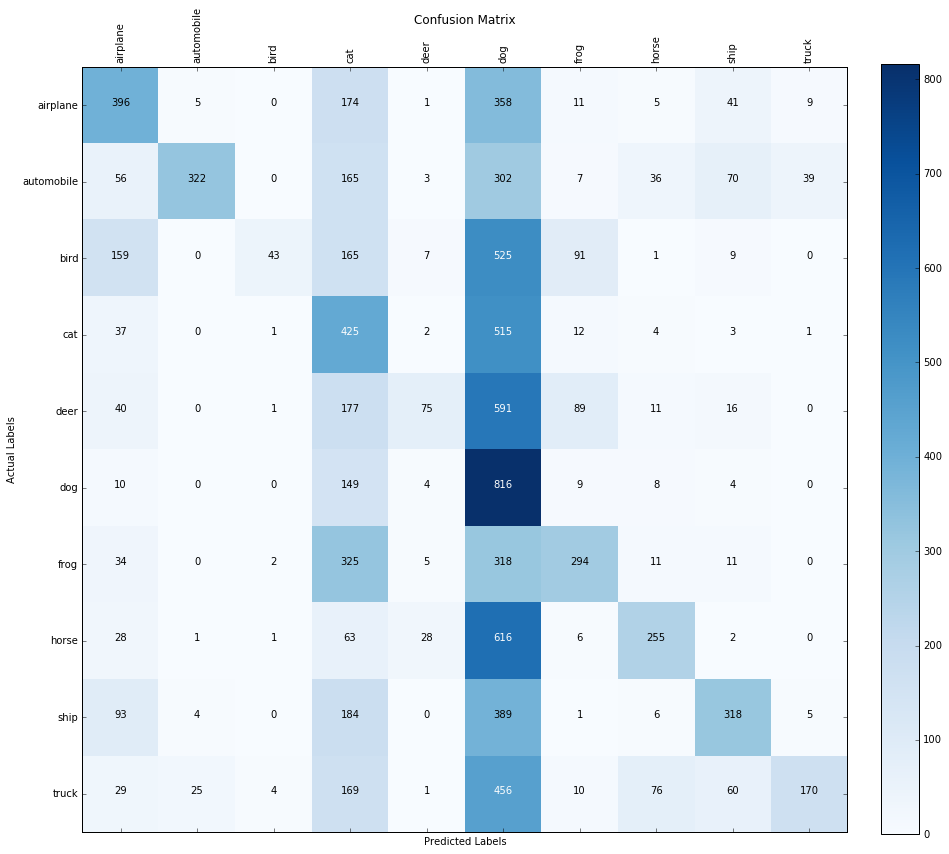

In [17]:
display_confusion_matrix(test_file)